In [1]:
import pandas as pd
from data_utils import enumerate_strings
from sklearn import metrics
from keras.wrappers.scikit_learn import KerasClassifier
from classification_plots import plot_confusion_matrix, plot_learning_curve
import matplotlib.pyplot as plt
import os
import numpy as np

Using TensorFlow backend.


In [2]:
# Able to specify which GPU to use
os.environ["CUDA_VISIBLE_DEVICES"]="2"

orig_SR = 44100
orig_blocksize = int(orig_SR/2)
orig_overlap = int(orig_SR/4)

SR = 16000
blocksize = int(SR/2)
overlap = int(SR/4)

In [3]:
import warnings
warnings.filterwarnings('ignore')

# Setup

In [4]:
audio_dir = '../../data/FSDKaggle2018/train/'

In [5]:
path_to_db='../../data/FSDKaggle2018/'

# Load Dataset
Here we load the csv that describes each file in the dataset. We add a high level category that is defined in the ESC-50 documentation. This we realize is anthetical to true training, it is a stopgap for when we use NLP to classify tags into these categories.

In [6]:
dataset = pd.read_csv(path_to_db + 'meta/train.csv')
dataset = dataset.drop(['manually_verified', 'freesound_id', 'license'], axis=1)
classes = dataset.label.unique()
h_classes = ['Human & Animal', 'Interacting Materials', 'Musical Instruments']
mapping = {'Hi-hat': h_classes[2],
           'Saxophone': h_classes[2],
           'Trumpet': h_classes[2],
           'Glockenspiel': h_classes[2],
           'Cello': h_classes[2],
           'Knock': h_classes[1],
           'Gunshot_or_gunfire': h_classes[1],
           'Clarinet': h_classes[2],
           'Computer_keyboard': h_classes[1],
           'Keys_jangling': h_classes[1],
           'Snare_drum': h_classes[2],
           'Writing': h_classes[1],
           'Laughter': h_classes[0],
           'Tearing': h_classes[1],
           'Fart': h_classes[1],
           'Oboe': h_classes[2],
           'Flute': h_classes[2],
           'Cough': h_classes[0],
           'Telephone': h_classes[1],
           'Bark': h_classes[0],
           'Chime': h_classes[2],
           'Bass_drum': h_classes[2],
           'Bus': h_classes[1],
           'Squeak': h_classes[0],
           'Scissors': h_classes[1],
           'Harmonica': h_classes[2],
           'Gong': h_classes[2],
           'Microwave_oven': h_classes[1],
           'Burping_or_eructation': h_classes[0],
           'Double_bass': h_classes[2],
           'Shatter': h_classes[1],
           'Fireworks': h_classes[1],
           'Tambourine': h_classes[2],
           'Cowbell': h_classes[2],
           'Electric_piano': h_classes[2],
           'Meow': h_classes[0],
           'Drawer_open_or_close': h_classes[1],
           'Applause': h_classes[1],
           'Acoustic_guitar': h_classes[2],
           'Violin_or_fiddle': h_classes[2],
           'Finger_snapping': h_classes[1]
           }
dataset['h_target'] = None
for index, row in dataset.iterrows():
    row['target'] = np.where(classes == row['label'])
    dataset.loc[index, 'h_target'] = mapping[row['label']]
dataset.columns = ['filename', 'target', 'h_target']
enum_map = enumerate_strings(dataset, ['filename'])

In [7]:
from sklearn.model_selection import StratifiedKFold

skf = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)
dataset['fold']=None
i = 1
for train_index, test_index in skf.split(dataset, np.zeros(len(dataset))):
    dataset.at[test_index, 'fold'] = i
    i += 1

In [8]:
dataset.head()

,filename,target,h_target,fold
0,00044347.wav,23,2,2
1,001ca53d.wav,30,2,5
2,002d256b.wav,38,2,3
3,0033e230.wav,19,2,1
4,00353774.wav,6,2,5


## Getting Preprocessed Data
We allow for previously preprocessed data to be retrieved for faster training turnaround. If the fold has been preprocessed, it is loaded but if not it is processed and saved.

In [9]:
import time
import librosa
import numpy as np
import soundfile as sf

def load_fold_audio_blockwise(fld, data, blocksize=1024, overlap=512, debug=False):
    start_time = time.time()
    f_df = data[data['fold'] == fld]
    items = []
    h_cat = []
    cat = []
    for i, sample in f_df.iterrows():
        if debug:
            print("File Processing", end="", flush=True)
        blockgen = sf.blocks(audio_dir + sample['filename'], 
                             blocksize=blocksize, 
                             overlap=overlap, 
                             always_2d=True, 
                             fill_value=0.0)
        sr = sf.info(audio_dir + sample['filename']).samplerate
        for bl in blockgen:
            if not np.any(bl):
                continue
            if debug:
                print(".", end="", flush=True)
            y = bl.transpose()
            y = librosa.resample(y, sr, SR)
            y = y[:int(blocksize)]
            y = y[np.newaxis, :]
            items.append(y)
            h_cat.append(sample.h_target)
            cat.append(sample.target)
        if debug:
            print("Done")

    print("\tProcessing Time: " + str(time.time() - start_time))
    return np.vstack(items), np.array(h_cat), np.array(cat)

def load_audio_blockwise(data, blocksize=1024, overlap=512, debug=False):
    start_time = time.time()
    items = []
    target = []
    for i, sample in data.iterrows():
        if debug:
            print("File Processing", end="", flush=True)
        blockgen = sf.blocks(audio_dir + sample['filename'], 
                             blocksize=blocksize, 
                             overlap=overlap, 
                             always_2d=True, 
                             fill_value=0.0)
        sr = sf.info(audio_dir + sample['filename']).samplerate
        for bl in blockgen:
            if not np.any(bl):
                continue
            if debug:
                print(".", end="", flush=True)
            y = bl.transpose()
            y = librosa.resample(y, sr, SR)
            y = y[:int(blocksize)]
            y = y[np.newaxis, :]
            items.append(y)
            target.append(sample.h_target)
        if debug:
            print("Done")
    print("\tProcessing Time: " + str(time.time() - start_time))
    return np.vstack(items), np.array(target)

In [10]:
c_data, targets, c_targets = load_fold_audio_blockwise(1, dataset, orig_blocksize, orig_overlap)
print(c_data.shape)

	Processing Time: 599.7353329658508
(3731, 1, 80000)


In [11]:
a_data = c_data[targets == 0]
a_targ = c_targets[targets == 0]
i_data = c_data[targets == 1]
i_targ = c_targets[targets == 1]

In [12]:
names_a = []
for name in np.unique(a_targ):
    names_a.append(classes[name])
names_i = []
for name in np.unique(i_targ):
    names_i.append(classes[name])
print(names_a)
print(names_i)

['Trumpet', 'Cello', 'Snare_drum', 'Gong', 'Microwave_oven', 'Electric_piano']
['Saxophone', 'Knock', 'Keys_jangling', 'Tearing', 'Oboe', 'Flute', 'Cough', 'Bass_drum', 'Scissors', 'Harmonica', 'Burping_or_eructation', 'Fireworks', 'Tambourine', 'Drawer_open_or_close', 'Applause', 'Finger_snapping']


In [13]:
from sklearn.model_selection import train_test_split
train_X, test_X, train_y, test_y = train_test_split(
                        c_data, targets, test_size=0.20, random_state=42)

In [14]:
plt.style.use('ggplot')
import keras
import kapre
from datetime import datetime
now = datetime.now()
import librosa
from librosa import display

def check_model(model):
    model.summary(line_length=80, positions=[.33, .65, .8, 1.])

    batch_input_shape = (2,) + model.input_shape[1:]
    batch_output_shape = (2,) + model.output_shape[1:]
    model.compile('sgd', 'mse')
    model.fit(np.random.uniform(size=batch_input_shape), np.random.uniform(size=batch_output_shape), epochs=1)

def visualise_model(model, src, logam=False):
    n_ch, nsp_src = model.input_shape[1:]
    print(src.shape)
    src = src[:nsp_src]
    src_batch = src[np.newaxis, :]
    pred = model.predict(x=src_batch)
    if keras.backend.image_data_format == 'channels_first':
        result = pred[0, 0]
    else:
        result = pred[0, :, :, 0]
    display.specshow(result, y_axis='linear', fmin=800, fmax=8000, sr=SR)
    plt.show()
    
def evaluate_model(model, c_data):
    pred = model.predict(x=c_data)
    if keras.backend.image_data_format == 'channels_first':
        result = pred[0, 0]
    else:
        result = pred[:, :, :, 0]
#     result = np.swapaxes(result, 1, 2)
    print(result.shape)
    return result

________________________________________________________________________________
Layer (type)              Output Shape              Param #     
melspectrogram_1 (Melspec (None, 128, 313, 1)       296064      
Total params: 296,064
Trainable params: 0
Non-trainable params: 296,064
________________________________________________________________________________
Epoch 1/1
2/2 [==============================] - 0s 66ms/step - loss: 1451.0653
(1, 80000)


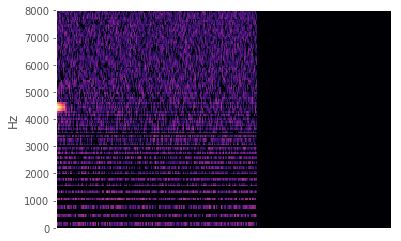

(3731, 128, 313)


In [15]:
import keras
import kapre
from keras.models import Sequential
from kapre.time_frequency import Melspectrogram, Spectrogram
from kapre.filterbank import Filterbank
import numpy as np

src = np.random.random((1, blocksize))
model = Sequential()
model.add(Melspectrogram(
    sr=44100,
    n_mels=128,
    power_melgram=2.0,
    return_decibel_melgram = True,
    input_shape=(1, blocksize),
    trainable_fb=False,
    fmin = 800,
    fmax = 8000
))

check_model(model)
visualise_model(model, c_data[1])
mfccs = evaluate_model(model, c_data)
n_targets = np.repeat(targets, mfccs.shape[1])
cat_targets = np.repeat(c_targets, mfccs.shape[1])

## High-Level Shallow Nets
Train binary shallow nets for high level categories(animals, natural, human, domestic, urban)

In [16]:
from keras.models import Sequential
from keras.layers import Dense, Dropout, Convolution2D, MaxPooling2D, Flatten, InputLayer
import keras.metrics as kmet
from kapre.time_frequency import Melspectrogram, Spectrogram
from kapre.utils import Normalization2D
from kapre.augmentation import AdditiveNoise

ensemble_num = 10
num_hidden_neurons = 10
dropout = 0.25

epochs = 100
batch = 128

def gpu_mfcc_shallow_net():
    # Create Model
    # Create Model
    model = Sequential()
    model.add(Melspectrogram(
        sr=SR,
        n_mels=128,
        power_melgram=1.0,
        input_shape=(1, blocksize),
        trainable_fb=False,
        fmin = 800,
        fmax = 8000
    ))
    model.add(Convolution2D(32, 9, 9, name='conv1', activation='relu'))
    model.add(MaxPooling2D((25, 17)))
    model.add(Flatten())
    model.add(Dense(32, activation='relu', input_shape=(128,)))
    model.add(Dropout(0.2))
    model.add(Dense(3, kernel_initializer='normal', activation='sigmoid'))
    
    # Compile model
    model.compile(loss='categorical_crossentropy',
                  optimizer='adam',
                  metrics=['accuracy', kmet.mae])
    
    model.summary()

    
    return model

In [17]:
frames = mfccs

In [18]:
frames = np.expand_dims(frames, axis=3)
frames.shape

(3731, 128, 313, 1)

In [19]:
clas = KerasClassifier(build_fn=gpu_mfcc_shallow_net, epochs=epochs, batch_size=batch, validation_split=0.15)
history = clas.fit(train_X, train_y)

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
melspectrogram_2 (Melspectro (None, 128, 313, 1)       296064    
_________________________________________________________________
conv1 (Conv2D)               (None, 120, 305, 32)      2624      
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 4, 17, 32)         0         
_________________________________________________________________
flatten_1 (Flatten)          (None, 2176)              0         
_________________________________________________________________
dense_1 (Dense)              (None, 32)                69664     
_________________________________________________________________
dropout_1 (Dropout)          (None, 32)                0         
_________________________________________________________________
dense_2 (Dense)              (None, 3)                 99        
Total para

2536/2536 [==============================] - 72s 28ms/step - loss: 0.5042 - acc: 0.7989 - mean_absolute_error: 0.2229 - val_loss: 0.7068 - val_acc: 0.7589 - val_mean_absolute_error: 0.2308
Epoch 36/100
2536/2536 [==============================] - 72s 28ms/step - loss: 0.4814 - acc: 0.8115 - mean_absolute_error: 0.2184 - val_loss: 0.7351 - val_acc: 0.7612 - val_mean_absolute_error: 0.2353
Epoch 37/100
2536/2536 [==============================] - 73s 29ms/step - loss: 0.4768 - acc: 0.8131 - mean_absolute_error: 0.2204 - val_loss: 0.7109 - val_acc: 0.7545 - val_mean_absolute_error: 0.2426
Epoch 38/100
2536/2536 [==============================] - 73s 29ms/step - loss: 0.4804 - acc: 0.8076 - mean_absolute_error: 0.2227 - val_loss: 0.7308 - val_acc: 0.7656 - val_mean_absolute_error: 0.2353
Epoch 39/100
2536/2536 [==============================] - 72s 28ms/step - loss: 0.4708 - acc: 0.8139 - mean_absolute_error: 0.2160 - val_loss: 0.7561 - val_acc: 0.7612 - val_mean_absolute_error: 0.2356
Epo

2536/2536 [==============================] - 71s 28ms/step - loss: 0.3686 - acc: 0.8533 - mean_absolute_error: 0.1987 - val_loss: 0.7794 - val_acc: 0.7723 - val_mean_absolute_error: 0.2169
Epoch 78/100
2536/2536 [==============================] - 73s 29ms/step - loss: 0.3668 - acc: 0.8529 - mean_absolute_error: 0.2000 - val_loss: 0.8096 - val_acc: 0.7723 - val_mean_absolute_error: 0.2246
Epoch 79/100
2536/2536 [==============================] - 72s 28ms/step - loss: 0.3524 - acc: 0.8592 - mean_absolute_error: 0.2024 - val_loss: 0.7704 - val_acc: 0.7746 - val_mean_absolute_error: 0.2223
Epoch 80/100
2536/2536 [==============================] - 75s 29ms/step - loss: 0.3627 - acc: 0.8569 - mean_absolute_error: 0.2008 - val_loss: 0.7474 - val_acc: 0.7746 - val_mean_absolute_error: 0.2254
Epoch 81/100
2536/2536 [==============================] - 74s 29ms/step - loss: 0.3558 - acc: 0.8620 - mean_absolute_error: 0.2008 - val_loss: 0.7560 - val_acc: 0.7746 - val_mean_absolute_error: 0.2234
Epo

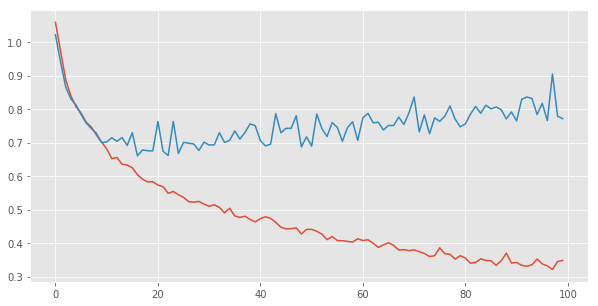

In [20]:
plt.figure(figsize=(10, 5))
# plt.ylim([0,9])
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.show()

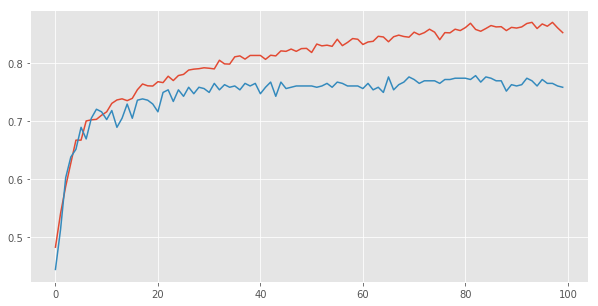

In [21]:
plt.figure(figsize=(10, 5))
# plt.ylim([0,9])
plt.plot(history.history['acc'])
plt.plot(history.history['val_acc'])
plt.show()

0.7550200803212851
Confusion matrix, without normalization
[[ 56  39  18]
 [ 22 229  57]
 [  8  39 279]]


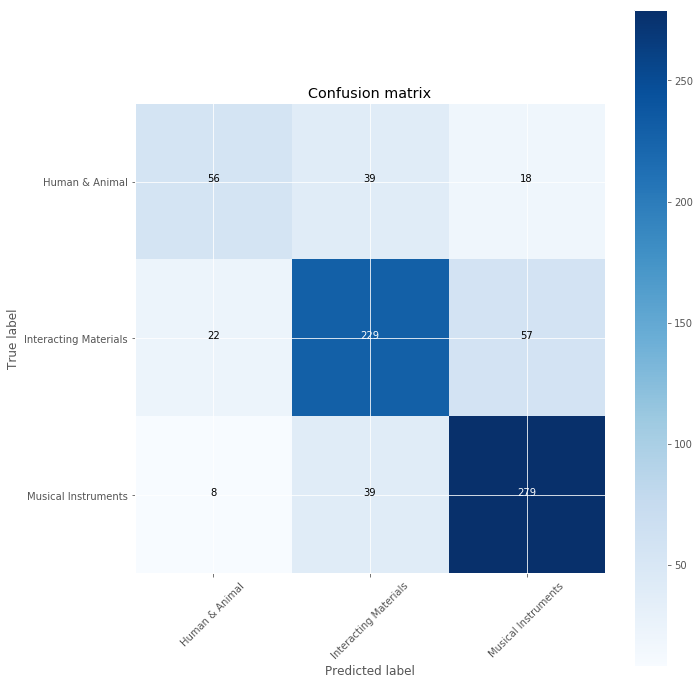

In [22]:
pred = clas.predict(test_X)
print(metrics.accuracy_score(test_y, pred))
cm = metrics.confusion_matrix(test_y, pred)
plt.figure(figsize=(10,10))
plot_confusion_matrix(cm, h_classes)
plt.show()

# Deep Net
Separate into classes

# Animal Sounds

In [23]:
train_X, test_X, train_y, test_y = train_test_split(
                        a_data, a_targ, test_size=0.20, random_state=56)

In [24]:
def gpu_mfcc_deep_net_a():
    # Create Model
    model = Sequential()
    model.add(Melspectrogram(
        sr=44100,
        n_mels=128,
        power_melgram=2.0,
        return_decibel_melgram = True,
        input_shape=(1, blocksize),
        trainable_fb=False,
        fmin = 800,
        fmax = 8000
    ))
    model.add(Convolution2D(32, (3, 3), name='conv1', activation='relu'))
    model.add(MaxPooling2D((25, 17)))
    model.add(Flatten())
    model.add(Dense(128, activation='relu', input_shape=(32,)))
    model.add(Dropout(0.2))
    model.add(Dense(128, activation='relu'))
    model.add(Dropout(0.2))
    model.add(Dense(64, activation='relu'))
    model.add(Dense(64, activation='relu'))
    model.add(Dropout(0.2))
    model.add(Dense(64, activation='relu'))
    model.add(Dropout(0.2))
    model.add(Dense(6, kernel_initializer='normal', activation='softmax'))
    
    # Compile model
    model.compile(loss='categorical_crossentropy',
                  optimizer='adam',
                  metrics=['accuracy', kmet.mae])
    
    model.summary()

    
    return model

In [25]:
anim = KerasClassifier(build_fn=gpu_mfcc_deep_net_a, 
                       epochs=epochs * 2, 
                       batch_size=batch, 
                       validation_split=0.15)
history = anim.fit(train_X, train_y)

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
melspectrogram_3 (Melspectro (None, 128, 313, 1)       296064    
_________________________________________________________________
conv1 (Conv2D)               (None, 126, 311, 32)      320       
_________________________________________________________________
max_pooling2d_2 (MaxPooling2 (None, 5, 18, 32)         0         
_________________________________________________________________
flatten_2 (Flatten)          (None, 2880)              0         
_________________________________________________________________
dense_3 (Dense)              (None, 128)               368768    
_________________________________________________________________
dropout_2 (Dropout)          (None, 128)               0         
_________________________________________________________________
dense_4 (Dense)              (None, 128)               16512     
__________

382/382 [==============================] - 3s 9ms/step - loss: 1.6532 - acc: 0.2827 - mean_absolute_error: 0.2596 - val_loss: 1.5817 - val_acc: 0.3382 - val_mean_absolute_error: 0.2588
Epoch 32/200
382/382 [==============================] - 4s 9ms/step - loss: 1.6199 - acc: 0.3141 - mean_absolute_error: 0.2599 - val_loss: 1.5839 - val_acc: 0.3529 - val_mean_absolute_error: 0.2593
Epoch 33/200
382/382 [==============================] - 4s 9ms/step - loss: 1.6357 - acc: 0.2801 - mean_absolute_error: 0.2613 - val_loss: 1.5601 - val_acc: 0.3676 - val_mean_absolute_error: 0.2564
Epoch 34/200
382/382 [==============================] - 4s 9ms/step - loss: 1.6181 - acc: 0.3272 - mean_absolute_error: 0.2580 - val_loss: 1.5405 - val_acc: 0.3529 - val_mean_absolute_error: 0.2530
Epoch 35/200
382/382 [==============================] - 4s 10ms/step - loss: 1.6153 - acc: 0.2906 - mean_absolute_error: 0.2578 - val_loss: 1.5343 - val_acc: 0.3676 - val_mean_absolute_error: 0.2527
Epoch 36/200
382/382 [

382/382 [==============================] - 4s 9ms/step - loss: 1.0697 - acc: 0.5524 - mean_absolute_error: 0.1740 - val_loss: 1.8981 - val_acc: 0.3676 - val_mean_absolute_error: 0.2234
Epoch 73/200
382/382 [==============================] - 3s 9ms/step - loss: 1.1215 - acc: 0.5366 - mean_absolute_error: 0.1840 - val_loss: 1.6693 - val_acc: 0.3971 - val_mean_absolute_error: 0.2182
Epoch 74/200
382/382 [==============================] - 4s 10ms/step - loss: 1.1095 - acc: 0.5262 - mean_absolute_error: 0.1810 - val_loss: 1.6875 - val_acc: 0.4265 - val_mean_absolute_error: 0.2195
Epoch 75/200
382/382 [==============================] - 3s 9ms/step - loss: 1.1016 - acc: 0.5602 - mean_absolute_error: 0.1777 - val_loss: 1.7746 - val_acc: 0.3971 - val_mean_absolute_error: 0.2222
Epoch 76/200
382/382 [==============================] - 4s 10ms/step - loss: 1.0660 - acc: 0.5366 - mean_absolute_error: 0.1723 - val_loss: 1.7075 - val_acc: 0.4265 - val_mean_absolute_error: 0.2191
Epoch 77/200
382/382 

382/382 [==============================] - 4s 10ms/step - loss: 0.6827 - acc: 0.7277 - mean_absolute_error: 0.1152 - val_loss: 2.5979 - val_acc: 0.4118 - val_mean_absolute_error: 0.2069
Epoch 114/200
382/382 [==============================] - 3s 9ms/step - loss: 0.6816 - acc: 0.7408 - mean_absolute_error: 0.1192 - val_loss: 2.3821 - val_acc: 0.3382 - val_mean_absolute_error: 0.2223
Epoch 115/200
382/382 [==============================] - 3s 9ms/step - loss: 0.7140 - acc: 0.7094 - mean_absolute_error: 0.1263 - val_loss: 2.2270 - val_acc: 0.4118 - val_mean_absolute_error: 0.2103
Epoch 116/200
382/382 [==============================] - 4s 10ms/step - loss: 0.6855 - acc: 0.7330 - mean_absolute_error: 0.1201 - val_loss: 2.5116 - val_acc: 0.3971 - val_mean_absolute_error: 0.2096
Epoch 117/200
382/382 [==============================] - 3s 9ms/step - loss: 0.6690 - acc: 0.7173 - mean_absolute_error: 0.1186 - val_loss: 2.6122 - val_acc: 0.3529 - val_mean_absolute_error: 0.2159
Epoch 118/200
382

382/382 [==============================] - 4s 10ms/step - loss: 0.4935 - acc: 0.8010 - mean_absolute_error: 0.0799 - val_loss: 3.3074 - val_acc: 0.4118 - val_mean_absolute_error: 0.2096
Epoch 155/200
382/382 [==============================] - 3s 9ms/step - loss: 0.3983 - acc: 0.8298 - mean_absolute_error: 0.0706 - val_loss: 3.2082 - val_acc: 0.3824 - val_mean_absolute_error: 0.2106
Epoch 156/200
382/382 [==============================] - 4s 10ms/step - loss: 0.4452 - acc: 0.8089 - mean_absolute_error: 0.0777 - val_loss: 3.3073 - val_acc: 0.3824 - val_mean_absolute_error: 0.2117
Epoch 157/200
382/382 [==============================] - 4s 9ms/step - loss: 0.4083 - acc: 0.8246 - mean_absolute_error: 0.0704 - val_loss: 3.1002 - val_acc: 0.3824 - val_mean_absolute_error: 0.2075
Epoch 158/200
382/382 [==============================] - 4s 11ms/step - loss: 0.3751 - acc: 0.8377 - mean_absolute_error: 0.0677 - val_loss: 2.9243 - val_acc: 0.4265 - val_mean_absolute_error: 0.1985
Epoch 159/200
38

382/382 [==============================] - 4s 10ms/step - loss: 0.2636 - acc: 0.9031 - mean_absolute_error: 0.0463 - val_loss: 4.1389 - val_acc: 0.3971 - val_mean_absolute_error: 0.2016
Epoch 196/200
382/382 [==============================] - 4s 10ms/step - loss: 0.2880 - acc: 0.9031 - mean_absolute_error: 0.0494 - val_loss: 4.1648 - val_acc: 0.4118 - val_mean_absolute_error: 0.2037
Epoch 197/200
382/382 [==============================] - 4s 11ms/step - loss: 0.3496 - acc: 0.8953 - mean_absolute_error: 0.0535 - val_loss: 3.8640 - val_acc: 0.4118 - val_mean_absolute_error: 0.2076
Epoch 198/200
382/382 [==============================] - 4s 10ms/step - loss: 0.2499 - acc: 0.9162 - mean_absolute_error: 0.0478 - val_loss: 3.7877 - val_acc: 0.3529 - val_mean_absolute_error: 0.2135
Epoch 199/200
382/382 [==============================] - 4s 10ms/step - loss: 0.2888 - acc: 0.9215 - mean_absolute_error: 0.0472 - val_loss: 3.4098 - val_acc: 0.3971 - val_mean_absolute_error: 0.1991
Epoch 200/200


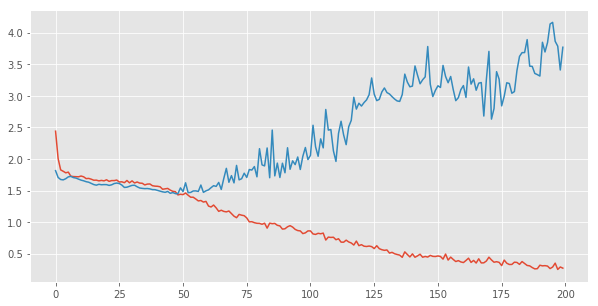

In [26]:
plt.figure(figsize=(10, 5))
# plt.ylim([0,9])
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.show()

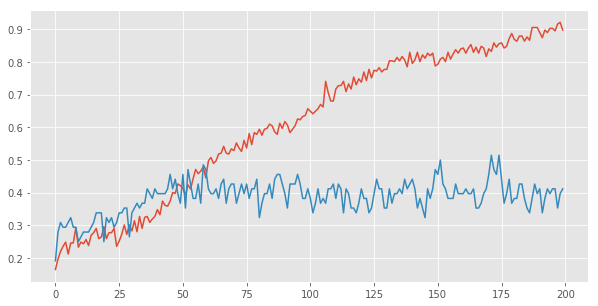

In [27]:
plt.figure(figsize=(10, 5))
# plt.ylim([0,9])
plt.plot(history.history['acc'])
plt.plot(history.history['val_acc'])
plt.show()

0.45132743362831856
Confusion matrix, without normalization
[[19  1  2  5  0  0]
 [ 1  1  1  1  0  0]
 [ 2  1  6  5  1  7]
 [ 5  0  4 13  0  6]
 [ 2  0  0  3  0  2]
 [ 5  0  1  7  0 12]]


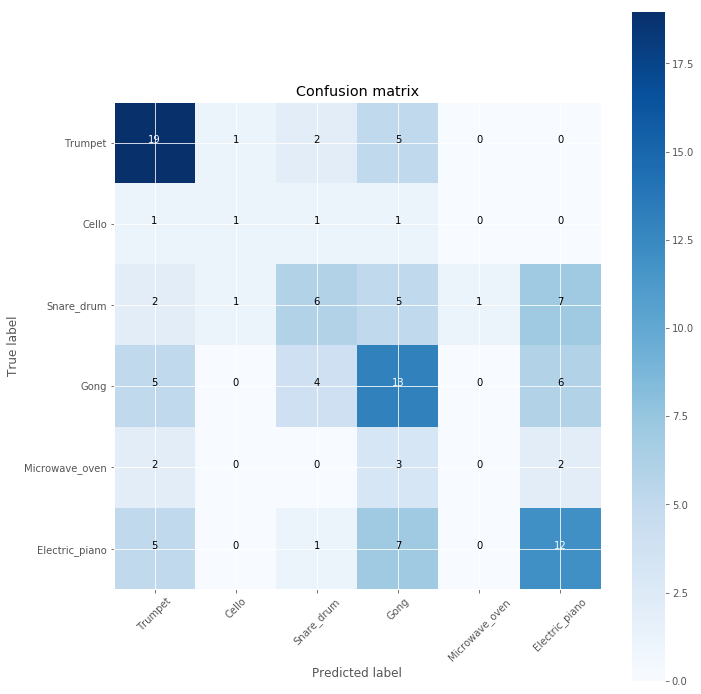

In [28]:
pred = anim.predict(test_X)
print(metrics.accuracy_score(test_y, pred))
cm = metrics.confusion_matrix(test_y, pred)
plt.figure(figsize=(10,10))
plot_confusion_matrix(cm, names_a)
plt.show()

# Interacting Materials

In [29]:
train_X, test_X, train_y, test_y = train_test_split(
                        i_data, i_targ, test_size=0.20, random_state=75)

In [30]:
def gpu_mfcc_deep_net_i():
    # Create Model
    model = Sequential()
    model.add(Melspectrogram(
        sr=44100,
        n_mels=128,
        power_melgram=2.0,
        return_decibel_melgram = True,
        input_shape=(1, blocksize),
        trainable_fb=False,
        fmin = 800,
        fmax = 8000
    ))
    model.add(Convolution2D(16, (3,3), name='conv1', activation='relu'))
    model.add(MaxPooling2D((25, 17)))
    model.add(Convolution2D(32, (5,2), name='conv2', activation='relu'))
    model.add(Flatten())
    model.add(Dense(128, activation='relu', input_shape=(32,)))
    model.add(Dropout(0.2))
    model.add(Dense(128, activation='relu'))
    model.add(Dropout(0.2))
    model.add(Dense(64, activation='relu'))
    model.add(Dense(64, activation='relu'))
    model.add(Dense(64, activation='relu'))
    model.add(Dropout(0.2))
    model.add(Dense(16, kernel_initializer='normal', activation='softmax'))
    
    # Compile model
    model.compile(loss='categorical_crossentropy',
                  optimizer='adam',
                  metrics=['accuracy', kmet.mae])
    
    model.summary()

    
    return model

In [31]:
inter = KerasClassifier(build_fn=gpu_mfcc_deep_net_i, epochs=epochs * 2, batch_size=batch, validation_split=0.15)
history = inter.fit(train_X, train_y)

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
melspectrogram_4 (Melspectro (None, 128, 313, 1)       296064    
_________________________________________________________________
conv1 (Conv2D)               (None, 126, 311, 16)      160       
_________________________________________________________________
max_pooling2d_3 (MaxPooling2 (None, 5, 18, 16)         0         
_________________________________________________________________
conv2 (Conv2D)               (None, 1, 17, 32)         5152      
_________________________________________________________________
flatten_3 (Flatten)          (None, 544)               0         
_________________________________________________________________
dense_9 (Dense)              (None, 128)               69760     
_________________________________________________________________
dropout_6 (Dropout)          (None, 128)               0         
__________

965/965 [==============================] - 7s 7ms/step - loss: 2.1718 - acc: 0.2902 - mean_absolute_error: 0.1027 - val_loss: 2.3953 - val_acc: 0.2515 - val_mean_absolute_error: 0.1035
Epoch 32/200
965/965 [==============================] - 7s 7ms/step - loss: 2.1484 - acc: 0.2902 - mean_absolute_error: 0.1008 - val_loss: 2.2930 - val_acc: 0.2573 - val_mean_absolute_error: 0.1036
Epoch 33/200
965/965 [==============================] - 7s 7ms/step - loss: 2.1641 - acc: 0.2902 - mean_absolute_error: 0.1025 - val_loss: 2.3492 - val_acc: 0.2515 - val_mean_absolute_error: 0.1047
Epoch 34/200
965/965 [==============================] - 7s 7ms/step - loss: 2.1521 - acc: 0.2798 - mean_absolute_error: 0.1018 - val_loss: 2.2655 - val_acc: 0.2865 - val_mean_absolute_error: 0.1039
Epoch 35/200
965/965 [==============================] - 7s 7ms/step - loss: 2.1427 - acc: 0.2902 - mean_absolute_error: 0.1003 - val_loss: 2.3845 - val_acc: 0.2456 - val_mean_absolute_error: 0.1038
Epoch 36/200
965/965 [=

965/965 [==============================] - 7s 7ms/step - loss: 1.5214 - acc: 0.4850 - mean_absolute_error: 0.0817 - val_loss: 2.6058 - val_acc: 0.3392 - val_mean_absolute_error: 0.0966
Epoch 73/200
965/965 [==============================] - 7s 7ms/step - loss: 1.5247 - acc: 0.4881 - mean_absolute_error: 0.0811 - val_loss: 2.5429 - val_acc: 0.2924 - val_mean_absolute_error: 0.0991
Epoch 74/200
965/965 [==============================] - 7s 7ms/step - loss: 1.5107 - acc: 0.4642 - mean_absolute_error: 0.0805 - val_loss: 2.5363 - val_acc: 0.3216 - val_mean_absolute_error: 0.0972
Epoch 75/200
965/965 [==============================] - 7s 7ms/step - loss: 1.4566 - acc: 0.5036 - mean_absolute_error: 0.0800 - val_loss: 2.7571 - val_acc: 0.2807 - val_mean_absolute_error: 0.0970
Epoch 76/200
965/965 [==============================] - 7s 7ms/step - loss: 1.3968 - acc: 0.4995 - mean_absolute_error: 0.0759 - val_loss: 2.6777 - val_acc: 0.3333 - val_mean_absolute_error: 0.0957
Epoch 77/200
965/965 [=

965/965 [==============================] - 7s 7ms/step - loss: 0.8347 - acc: 0.7212 - mean_absolute_error: 0.0491 - val_loss: 3.6536 - val_acc: 0.3216 - val_mean_absolute_error: 0.0907
Epoch 114/200
965/965 [==============================] - 7s 7ms/step - loss: 0.8649 - acc: 0.7067 - mean_absolute_error: 0.0501 - val_loss: 3.6666 - val_acc: 0.3333 - val_mean_absolute_error: 0.0898
Epoch 115/200
965/965 [==============================] - 7s 7ms/step - loss: 0.8403 - acc: 0.7275 - mean_absolute_error: 0.0478 - val_loss: 3.7698 - val_acc: 0.3041 - val_mean_absolute_error: 0.0915
Epoch 116/200
965/965 [==============================] - 7s 7ms/step - loss: 0.7982 - acc: 0.7098 - mean_absolute_error: 0.0476 - val_loss: 3.3016 - val_acc: 0.3567 - val_mean_absolute_error: 0.0890
Epoch 117/200
965/965 [==============================] - 7s 7ms/step - loss: 0.8056 - acc: 0.7285 - mean_absolute_error: 0.0475 - val_loss: 3.5909 - val_acc: 0.3333 - val_mean_absolute_error: 0.0881
Epoch 118/200
965/9

965/965 [==============================] - 7s 7ms/step - loss: 0.5731 - acc: 0.8052 - mean_absolute_error: 0.0335 - val_loss: 4.0753 - val_acc: 0.3216 - val_mean_absolute_error: 0.0888
Epoch 155/200
965/965 [==============================] - 7s 7ms/step - loss: 0.5776 - acc: 0.7990 - mean_absolute_error: 0.0347 - val_loss: 4.3750 - val_acc: 0.3041 - val_mean_absolute_error: 0.0894
Epoch 156/200
965/965 [==============================] - 7s 7ms/step - loss: 0.5262 - acc: 0.8187 - mean_absolute_error: 0.0316 - val_loss: 4.3613 - val_acc: 0.3216 - val_mean_absolute_error: 0.0887
Epoch 157/200
965/965 [==============================] - 7s 7ms/step - loss: 0.4914 - acc: 0.8477 - mean_absolute_error: 0.0293 - val_loss: 4.3184 - val_acc: 0.3041 - val_mean_absolute_error: 0.0898
Epoch 158/200
965/965 [==============================] - 7s 7ms/step - loss: 0.5220 - acc: 0.8269 - mean_absolute_error: 0.0309 - val_loss: 4.2279 - val_acc: 0.2982 - val_mean_absolute_error: 0.0890
Epoch 159/200
965/9

965/965 [==============================] - 7s 7ms/step - loss: 0.4119 - acc: 0.8653 - mean_absolute_error: 0.0240 - val_loss: 4.2473 - val_acc: 0.3216 - val_mean_absolute_error: 0.0884
Epoch 196/200
965/965 [==============================] - 7s 7ms/step - loss: 0.4034 - acc: 0.8694 - mean_absolute_error: 0.0237 - val_loss: 4.8531 - val_acc: 0.2982 - val_mean_absolute_error: 0.0890
Epoch 197/200
965/965 [==============================] - 7s 7ms/step - loss: 0.4658 - acc: 0.8508 - mean_absolute_error: 0.0260 - val_loss: 4.4138 - val_acc: 0.2865 - val_mean_absolute_error: 0.0916
Epoch 198/200
965/965 [==============================] - 7s 7ms/step - loss: 0.4465 - acc: 0.8518 - mean_absolute_error: 0.0263 - val_loss: 4.2824 - val_acc: 0.2865 - val_mean_absolute_error: 0.0894
Epoch 199/200
965/965 [==============================] - 7s 7ms/step - loss: 0.4200 - acc: 0.8694 - mean_absolute_error: 0.0259 - val_loss: 4.3667 - val_acc: 0.3450 - val_mean_absolute_error: 0.0877
Epoch 200/200
965/9

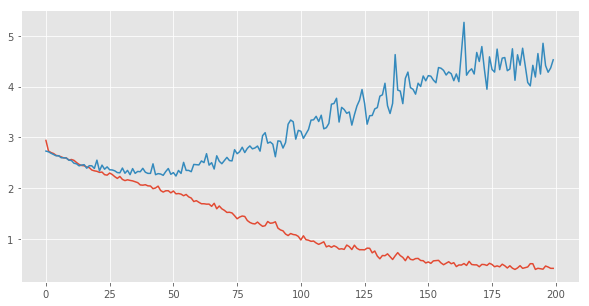

In [32]:
plt.figure(figsize=(10, 5))
# plt.ylim([0,9])
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.show()

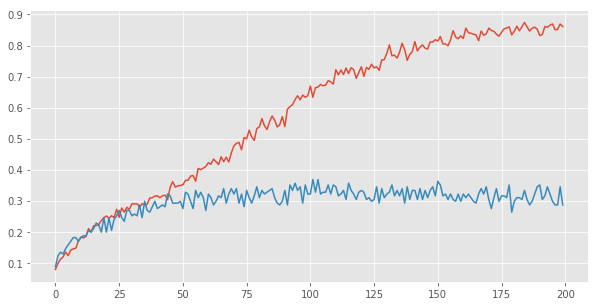

In [33]:
plt.figure(figsize=(10, 5))
# plt.ylim([0,9])
plt.plot(history.history['acc'])
plt.plot(history.history['val_acc'])
plt.show()

0.3415492957746479
Confusion matrix, without normalization
[[20  2  0  1  2  0  5  0  0  1  1  0  0  2  0  0]
 [ 4 11  0  1  2  0  0  1  0  0  3  0  0  1  0  1]
 [ 0  0  5  0  0  1  0  0  0  0  0  0  0  4  1  2]
 [ 0  0  1  4  2  0  0  0  0  0  0  0  0  2  0  3]
 [ 1  0  1  1  3  0  1  0  0  0  1  0  0  0  0  1]
 [ 1  0  0  0  0  2  0  0  0  0  0  0  2  0  0  1]
 [ 3  5  0  3  2  0  5  1  0  0  0  0  0  4  0  2]
 [ 0  0  0  0  1  0  1  1  0  0  1  0  0  0  0  0]
 [ 0  1  1  1  1  0  2  0  3  0  1  2  1  1  0  1]
 [ 1  0  0  1  2  0  1  1  0  4  1  0  2  2  0  0]
 [ 0  6  0  2  0  0  0  0  1  2  2  0  1  0  0  0]
 [ 0  0  0  0  0  3  1  0  0  0  0  3  0  3  0  0]
 [ 2  0  0  0  2  4  1  0  1  1  0  0  5  2  0  0]
 [ 0  1  2  3  1  0  2  0  1  0  2  1  2  9  1  5]
 [ 1  0  0  0  1  0  1  0  1  1  0  0  1  0 11  0]
 [ 2  2  4  3  2  0  1  1  0  0  2  1  0 10  1  9]]


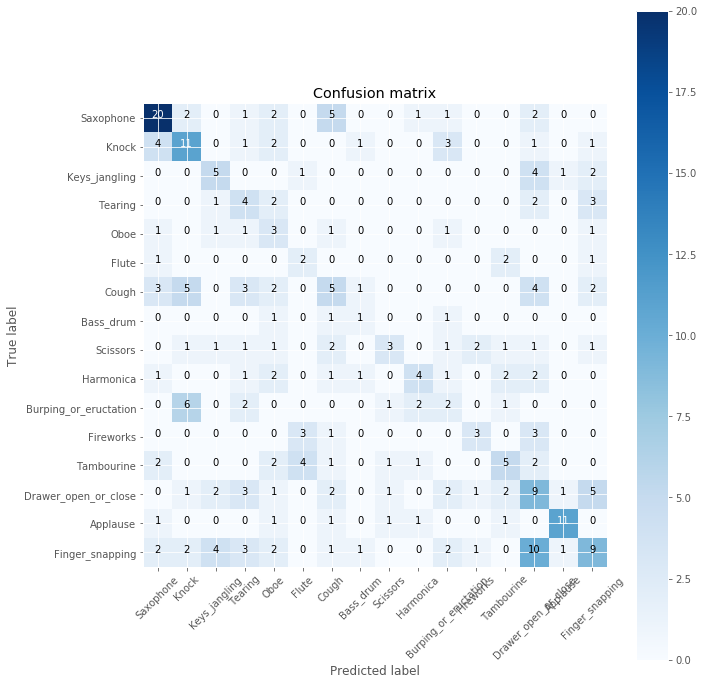

In [34]:
pred = inter.predict(test_X)
print(metrics.accuracy_score(test_y, pred))
cm = metrics.confusion_matrix(test_y, pred)
plt.figure(figsize=(10,10))
plot_confusion_matrix(cm, names_i)
plt.show()

# All Data
### Fold 2

In [35]:
X, y, yy = load_fold_audio_blockwise(2, dataset, orig_blocksize, orig_overlap)

	Processing Time: 567.8925378322601


0.7476190476190476
Confusion matrix, without normalization
[[ 303  175  109]
 [ 107  896  235]
 [  63  212 1470]]


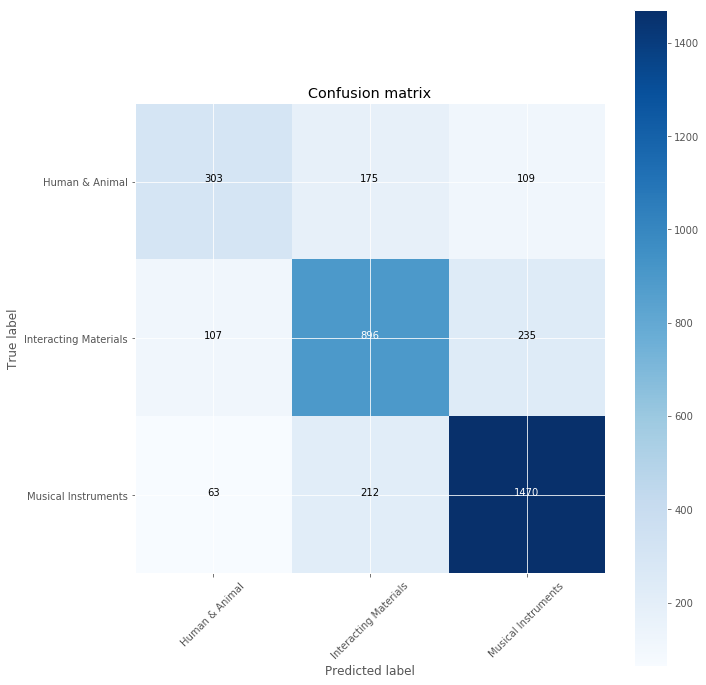

In [36]:
pred = clas.predict(X)
print(metrics.accuracy_score(y, pred))
cm = metrics.confusion_matrix(y, pred)
plt.figure(figsize=(10,10))
plot_confusion_matrix(cm, h_classes)
plt.show()

In [37]:
test_a_data = X[y == 0]
test_a_targ = yy[y == 0]
test_i_data = X[y == 1]
test_i_targ = yy[y == 1]

0.37649063032367974
Confusion matrix, without normalization
[[60  5 15 39  3 20]
 [10 14 12 16  1  9]
 [11  2 15 21  3 15]
 [19  1  9 72  3 11]
 [ 8  2  1 15  2 27]
 [20  2  9 51  6 58]]


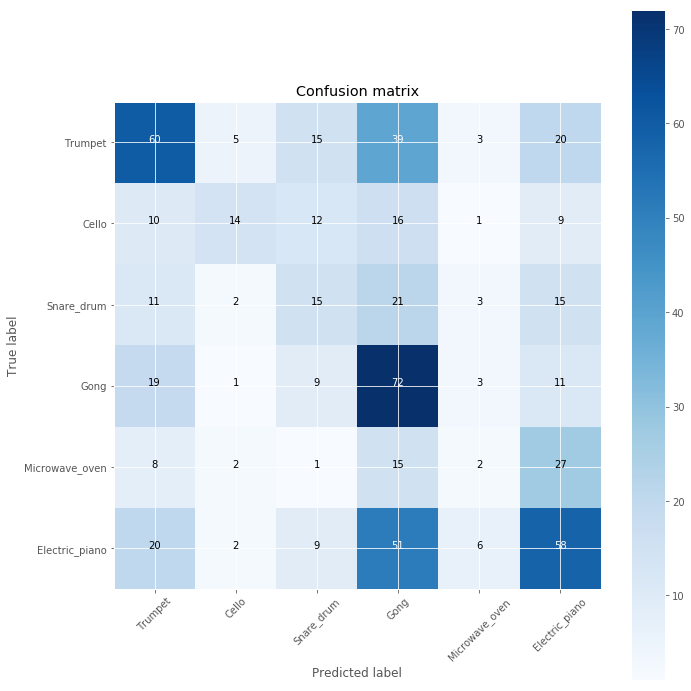

In [38]:
pred = anim.predict(test_a_data)
print(metrics.accuracy_score(test_a_targ, pred))
cm = metrics.confusion_matrix(test_a_targ, pred)
plt.figure(figsize=(10,10))
plot_confusion_matrix(cm, names_a)
plt.show()

0.3134087237479806
Confusion matrix, without normalization
[[123   3   1   0   2   0   2   0   1   0   2   1   0  14   2   2]
 [ 13  27   3   1   7   1   3   0   1   0  13   0   0   5   1   2]
 [  6   1  14   0   0   0   0   1   2   0   0   2   1   5   0   9]
 [  0   0   2   9   4   1   3   0   1   3   2   0   1   8   1   3]
 [  5   1   0   3  15   0   5   4   1   5   4   1   4   4   1   0]
 [  0   0   1   0   0  19   0   0   2   0   1   1   1   4   0   0]
 [ 24  10   5  11   8   0  30   1   5   3   4   0   5  14   3  10]
 [  2   1   0   2  17   0   8   8   0   1   5   0   2   6   0   2]
 [  2   0   4   4   1   0   2   0   9   0   2   6   0  15   1   2]
 [  1   1   1   7   5   1   2   1   0  30   5   0   2   7   0   9]
 [  5  25   3   4   1   0   7   1   5   2  16   0   3  10   7   7]
 [  0   0   7   3   0   2   0   0   4   1   0   1   1  13   0   3]
 [ 10   2   4   7  13   4  16   6   7   5   3   5  25  33   5   4]
 [ 10   1   4   9   5   1   3   1   8   2   3   3   5  27   7  11]
 [ 

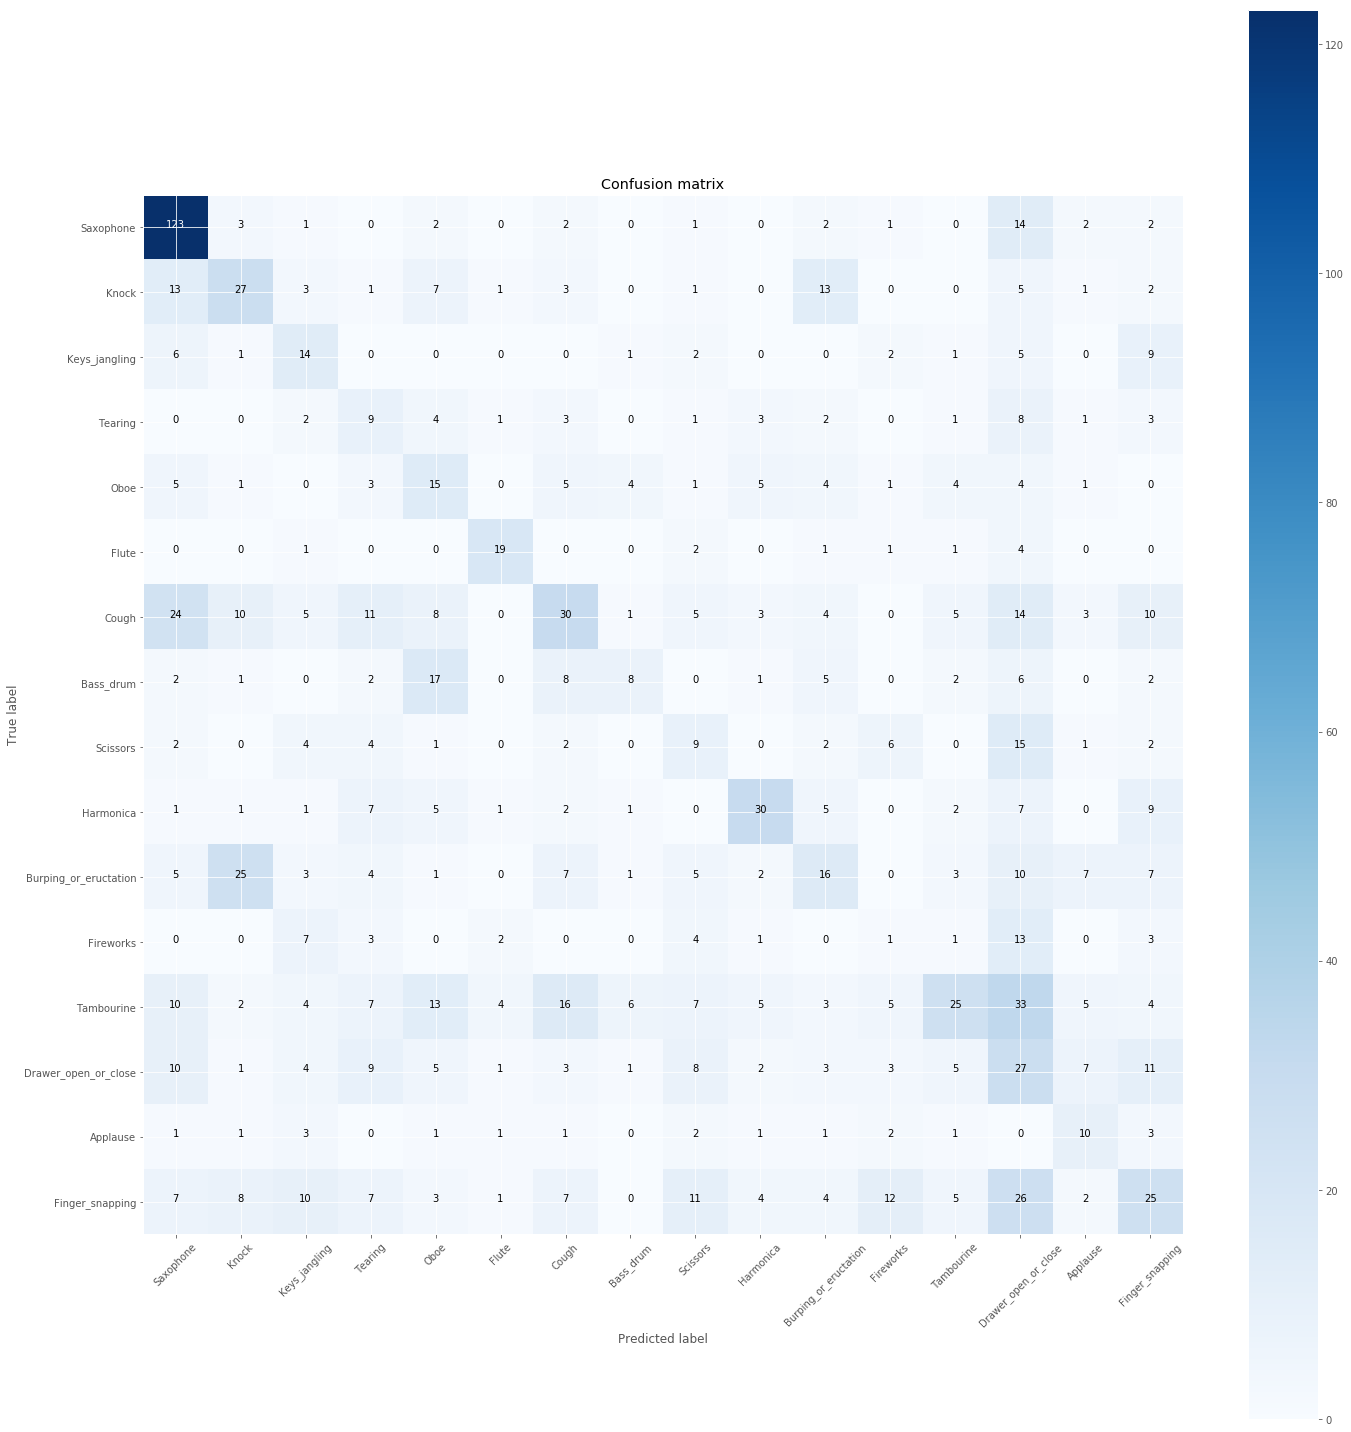

In [39]:
pred = inter.predict(test_i_data)
print(metrics.accuracy_score(test_i_targ, pred))
cm = metrics.confusion_matrix(test_i_targ, pred)
plt.figure(figsize=(20,20))
plot_confusion_matrix(cm, names_i)
plt.show()

### Fold 3

In [40]:
X, y, yy = load_fold_audio_blockwise(3, dataset, orig_blocksize, orig_overlap)

	Processing Time: 573.0101108551025


0.7674418604651163
Confusion matrix, without normalization
[[ 301  163   95]
 [ 107 1038  233]
 [  58  194 1466]]


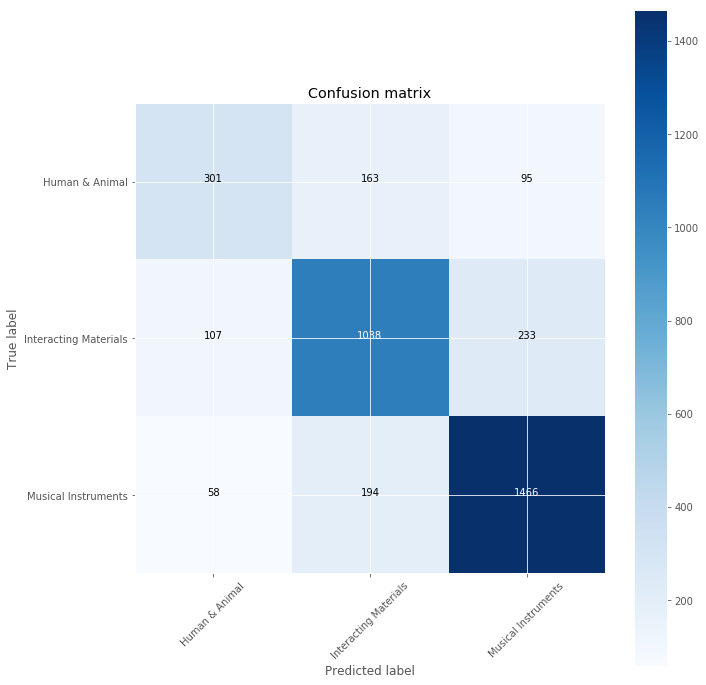

In [41]:
pred = clas.predict(X)
print(metrics.accuracy_score(y, pred))
cm = metrics.confusion_matrix(y, pred)
plt.figure(figsize=(10,10))
plot_confusion_matrix(cm, h_classes)
plt.show()

In [42]:
test_a_data = X[y == 0]
test_a_targ = yy[y == 0]
test_i_data = X[y == 1]
test_i_targ = yy[y == 1]

0.46332737030411447
Confusion matrix, without normalization
[[77  0 11 40  2 19]
 [10 13  4  4  4  4]
 [14  5 10 11  3  9]
 [16  1  3 91  3 10]
 [10  2  2 24  7 22]
 [20  4  6 34  3 61]]


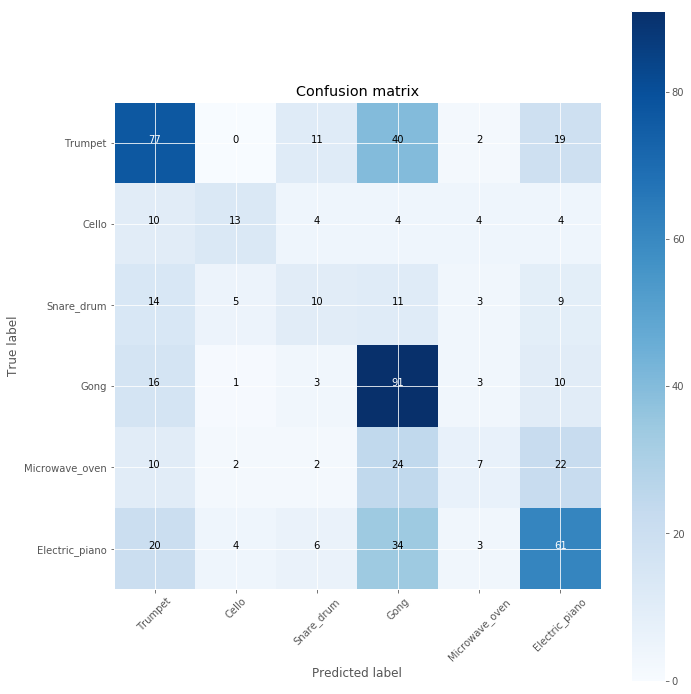

In [43]:
pred = anim.predict(test_a_data)
print(metrics.accuracy_score(test_a_targ, pred))
cm = metrics.confusion_matrix(test_a_targ, pred)
plt.figure(figsize=(10,10))
plot_confusion_matrix(cm, names_a)
plt.show()

0.32728592162554426
Confusion matrix, without normalization
[[125   8   3   1   5   0   7   1   1   0   0   2   2  11   1   4]
 [ 12  33   1   2   3   0   7   2   1   0   9   0   0   3   0   1]
 [  8   0  22   3   6   1   2   0   1   0   0   7   2  14   0   7]
 [  1   2   4  14   5   0   6   0   2   1   1   0   4  13   2   5]
 [  4   3   1   5  23   0   7   3   2   4   5   1   8   9   5   3]
 [  1   0   0   1   0  17   0   0   1   1   0   4   2   3   0   0]
 [  8  14   8  16  11   0  35   2   3   2   5   0   9   9   0  10]
 [  5   3   0   1   9   0   8   5   0   3   0   0   4   3   2   3]
 [  2   1   1   0   0   3   2   1   8   1   0   8   0   8   0   2]
 [  0   0   1   7  13   0   4   3   1  22   1   0   5   7   2   7]
 [  3  10   0   3   9   0   5   0   1   2  13   0   1   8   8   2]
 [  2   2   3   3   1   2   3   0  11   0   1   1   2  14   4   2]
 [  2   3   2   4   8   1  17   3   4   2   1   0  25  11   0   6]
 [ 17   2   8  10  11   1   9   3   5   1   7   3   7  39   3   7]
 [

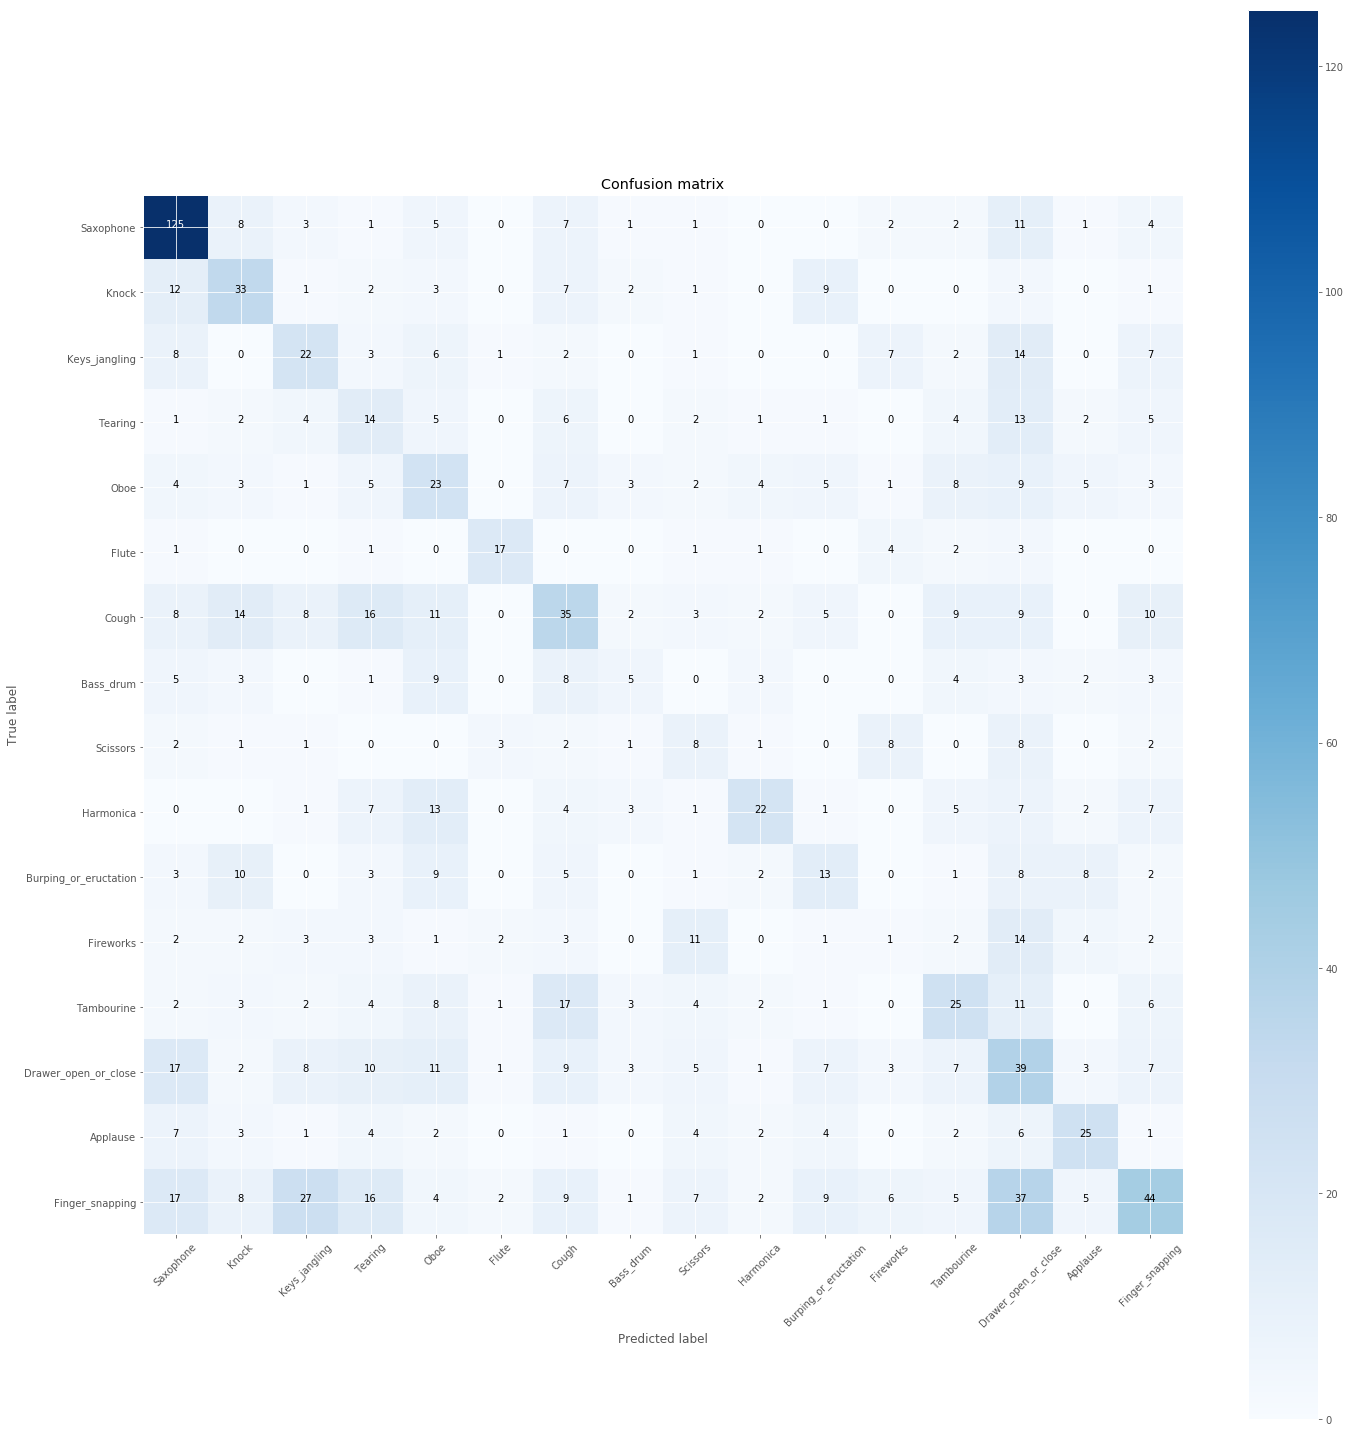

In [44]:
pred = inter.predict(test_i_data)
print(metrics.accuracy_score(test_i_targ, pred))
cm = metrics.confusion_matrix(test_i_targ, pred)
plt.figure(figsize=(20,20))
plot_confusion_matrix(cm, names_i)
plt.show()

### Fold 4

In [45]:
X, y, yy = load_fold_audio_blockwise(4, dataset, orig_blocksize, orig_overlap)

	Processing Time: 593.4528062343597


0.7491146826477799
Confusion matrix, without normalization
[[ 319  202  141]
 [ 100 1051  258]
 [  51  169 1380]]


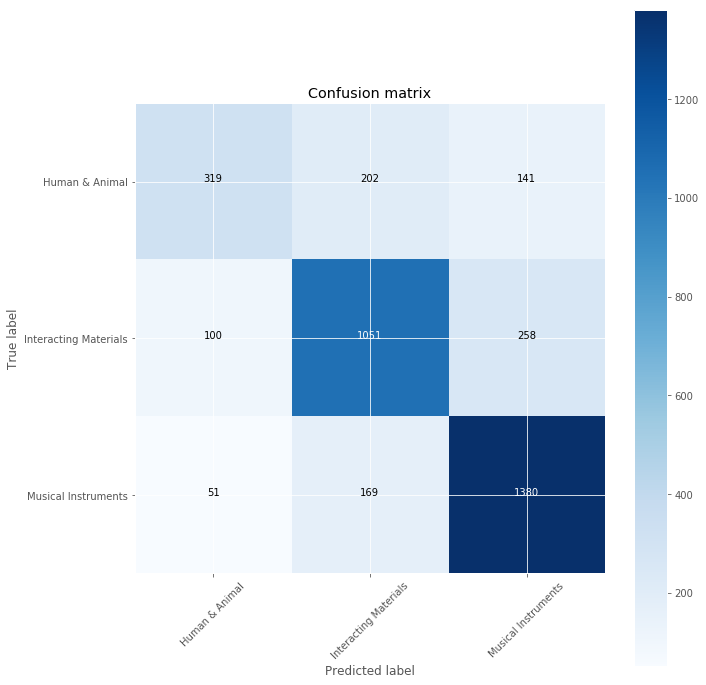

In [46]:
pred = clas.predict(X)
print(metrics.accuracy_score(y, pred))
cm = metrics.confusion_matrix(y, pred)
plt.figure(figsize=(10,10))
plot_confusion_matrix(cm, h_classes)
plt.show()

In [47]:
test_a_data = X[y == 0]
test_a_targ = yy[y == 0]
test_i_data = X[y == 1]
test_i_targ = yy[y == 1]

0.38972809667673713
Confusion matrix, without normalization
[[72  1  4 31  2 10]
 [12 11  8 11  6  7]
 [23  0 21 53  6 12]
 [14  2 16 77  5 20]
 [18  2  6 23 11 42]
 [26  1  8 27  8 66]]


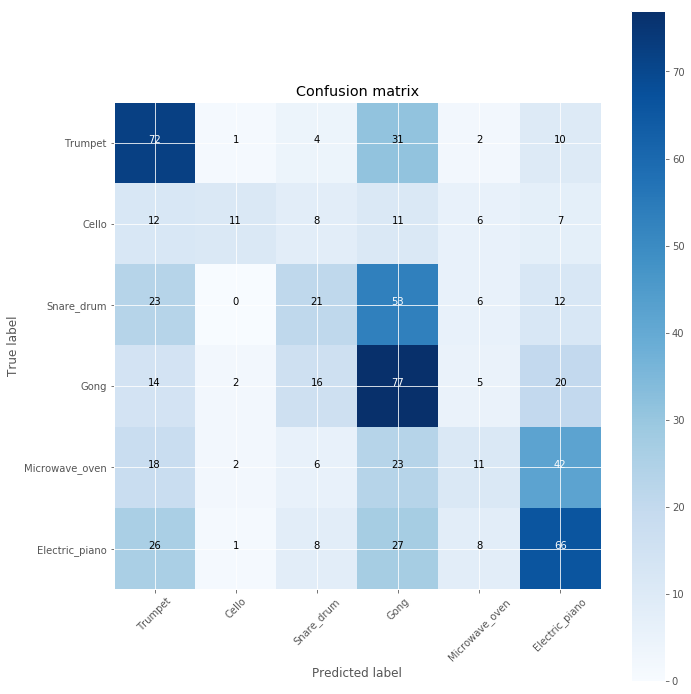

In [48]:
pred = anim.predict(test_a_data)
print(metrics.accuracy_score(test_a_targ, pred))
cm = metrics.confusion_matrix(test_a_targ, pred)
plt.figure(figsize=(10,10))
plot_confusion_matrix(cm, names_a)
plt.show()

0.31156848828956707
Confusion matrix, without normalization
[[142   2   1   0   2   1   3   1   0   0   0   0   2   8   0   2]
 [  9  31   0   2   4   0   6   1   1   0  14   0   1   3   1   1]
 [ 10   1  23   4   0   2   2   0   4   0   0   2   1  21   0   9]
 [  4   1   2  12   7   2   7   0   4   1   1   1   4  16   1   5]
 [  5   2   0   4  25   0   7   5   0   2   5   0   3  11   1   2]
 [  0   1   1   1   1  14   0   1   4   0   2   1   1   8   0   5]
 [ 29  22   6  16  10   1  26   1   1   2   2   2  11  20   3  20]
 [  3   1   0   2  12   0   8   4   1   0   2   1   4   4   1   2]
 [  8   3   7   4   3   4   2   0  18   0   3   6   1  30   1   5]
 [  4   3   3  18  11   0   6   2   2  23   8   0  10  20   3  13]
 [  0   9   0   4   5   0   2   1   4   7  15   0   0  12  13   4]
 [  1   0   6   0   0   2   1   0   4   0   0   5   2  14   0   3]
 [  2   2   0   4   9   3   8   3   6   6   1   3  23  17   2   4]
 [  9   2   5   9   9   2   8   1   5   0   3   1  12  41   8  10]
 [

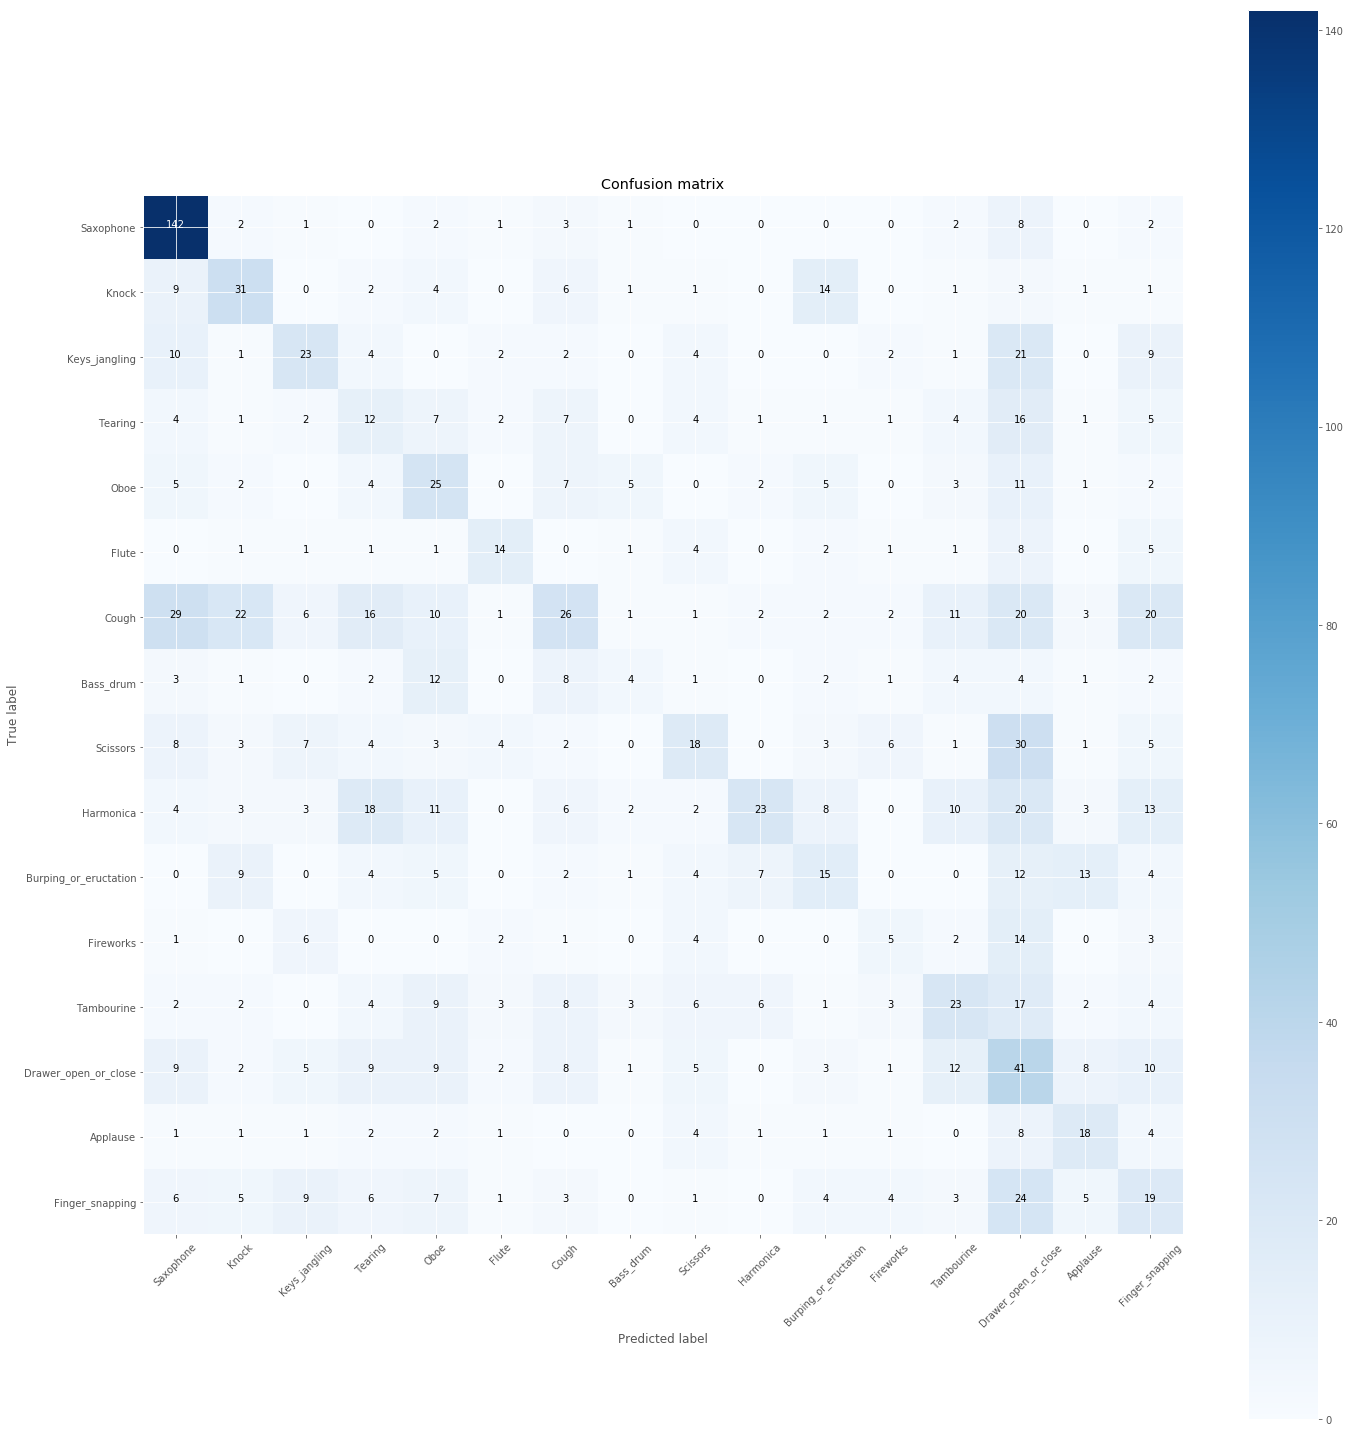

In [49]:
pred = inter.predict(test_i_data)
print(metrics.accuracy_score(test_i_targ, pred))
cm = metrics.confusion_matrix(test_i_targ, pred)
plt.figure(figsize=(20,20))
plot_confusion_matrix(cm, names_i)
plt.show()

### Fold 5

In [50]:
X, y, yy = load_fold_audio_blockwise(5, dataset, orig_blocksize, orig_overlap)

	Processing Time: 567.2789235115051


0.7755215577190543
Confusion matrix, without normalization
[[ 270  144  107]
 [  78 1069  217]
 [  64  197 1449]]


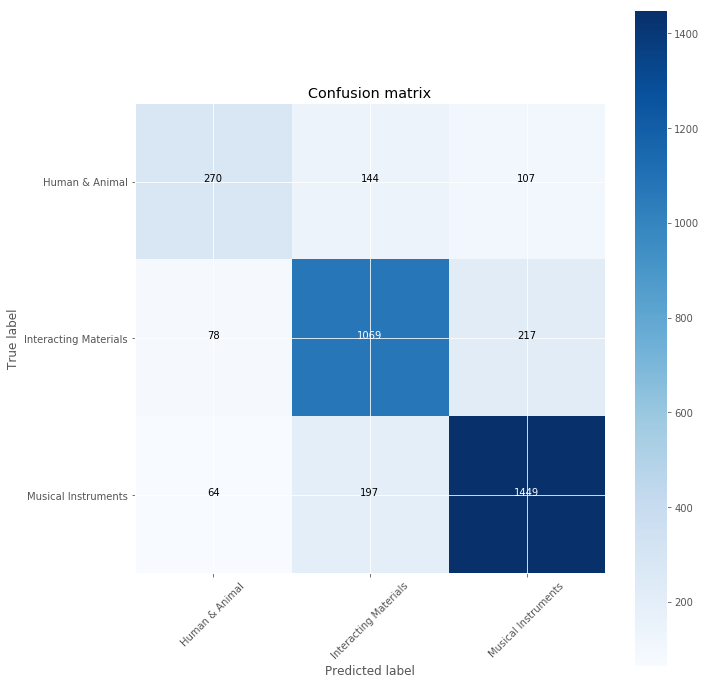

In [51]:
pred = clas.predict(X)
print(metrics.accuracy_score(y, pred))
cm = metrics.confusion_matrix(y, pred)
plt.figure(figsize=(10,10))
plot_confusion_matrix(cm, h_classes)
plt.show()

In [52]:
test_a_data = X[y == 0]
test_a_targ = yy[y == 0]
test_i_data = X[y == 1]
test_i_targ = yy[y == 1]

0.3550863723608445
Confusion matrix, without normalization
[[56  2  5 38  3 12]
 [15 14 10  9 13  7]
 [18  3 20 26  4 20]
 [16  1  7 37  5 10]
 [10  0  5 17  3 14]
 [11  2  7 39  7 55]]


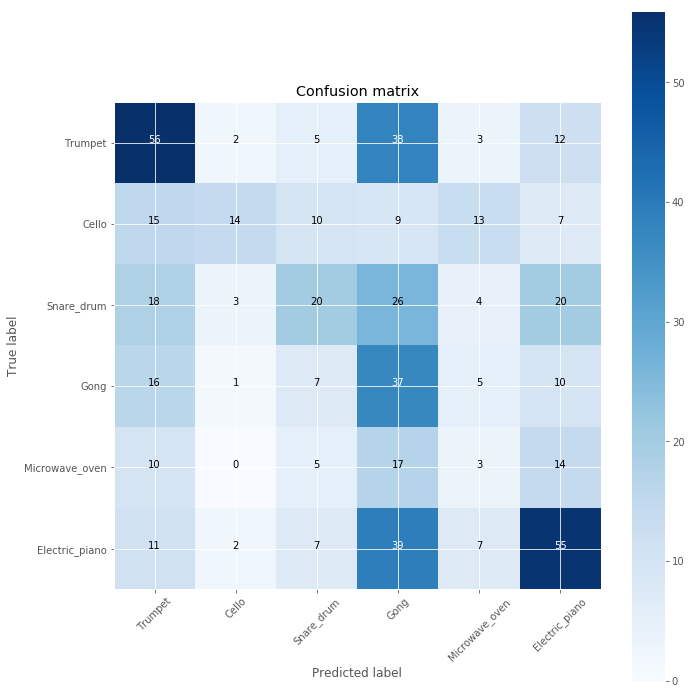

In [53]:
pred = anim.predict(test_a_data)
print(metrics.accuracy_score(test_a_targ, pred))
cm = metrics.confusion_matrix(test_a_targ, pred)
plt.figure(figsize=(10,10))
plot_confusion_matrix(cm, names_a)
plt.show()

0.3416422287390029
Confusion matrix, without normalization
[[140  11   2   4   1   0   7   0   0   0   1   0   1   9   0   3]
 [ 12  32   0   2   3   0   4   2   0   1   6   0   0   4   3   0]
 [ 11   0  11   2   2   0   1   1   5   1   1   4   2  12   0   7]
 [  4   1   2  20   9   0  10   0   1   1   1   0   4   9   1   5]
 [  9   1   1   4  38   0   5   2   4   5   8   1   7  12  12   3]
 [  0   0   3   0   0  16   0   0   1   0   0   1   1   6   0   1]
 [ 16  29   3  10  12   0  31   5   3   1   7   1   9  13   3  14]
 [  4   1   3   1  16   0   6   3   1   5   0   0   3   3   1   3]
 [  0   0   7   3   1   2   0   0  20   0   2   2   3  10   2   8]
 [  0   0   2   8   9   1   4   0   0  22   1   0   5   9   2   4]
 [  3  15   0   4   3   0   5   0   4   4  17   4   3   7   5   2]
 [  3   0   7   4   0   1   4   0  10   1   1   8   1  18   0   7]
 [  5   1   2   4   4   1   9   1   1   3   0   0  16   8   4   2]
 [ 16   3  10  12   7   1  11   0   4   2   4   8   7  35   1   7]
 [ 

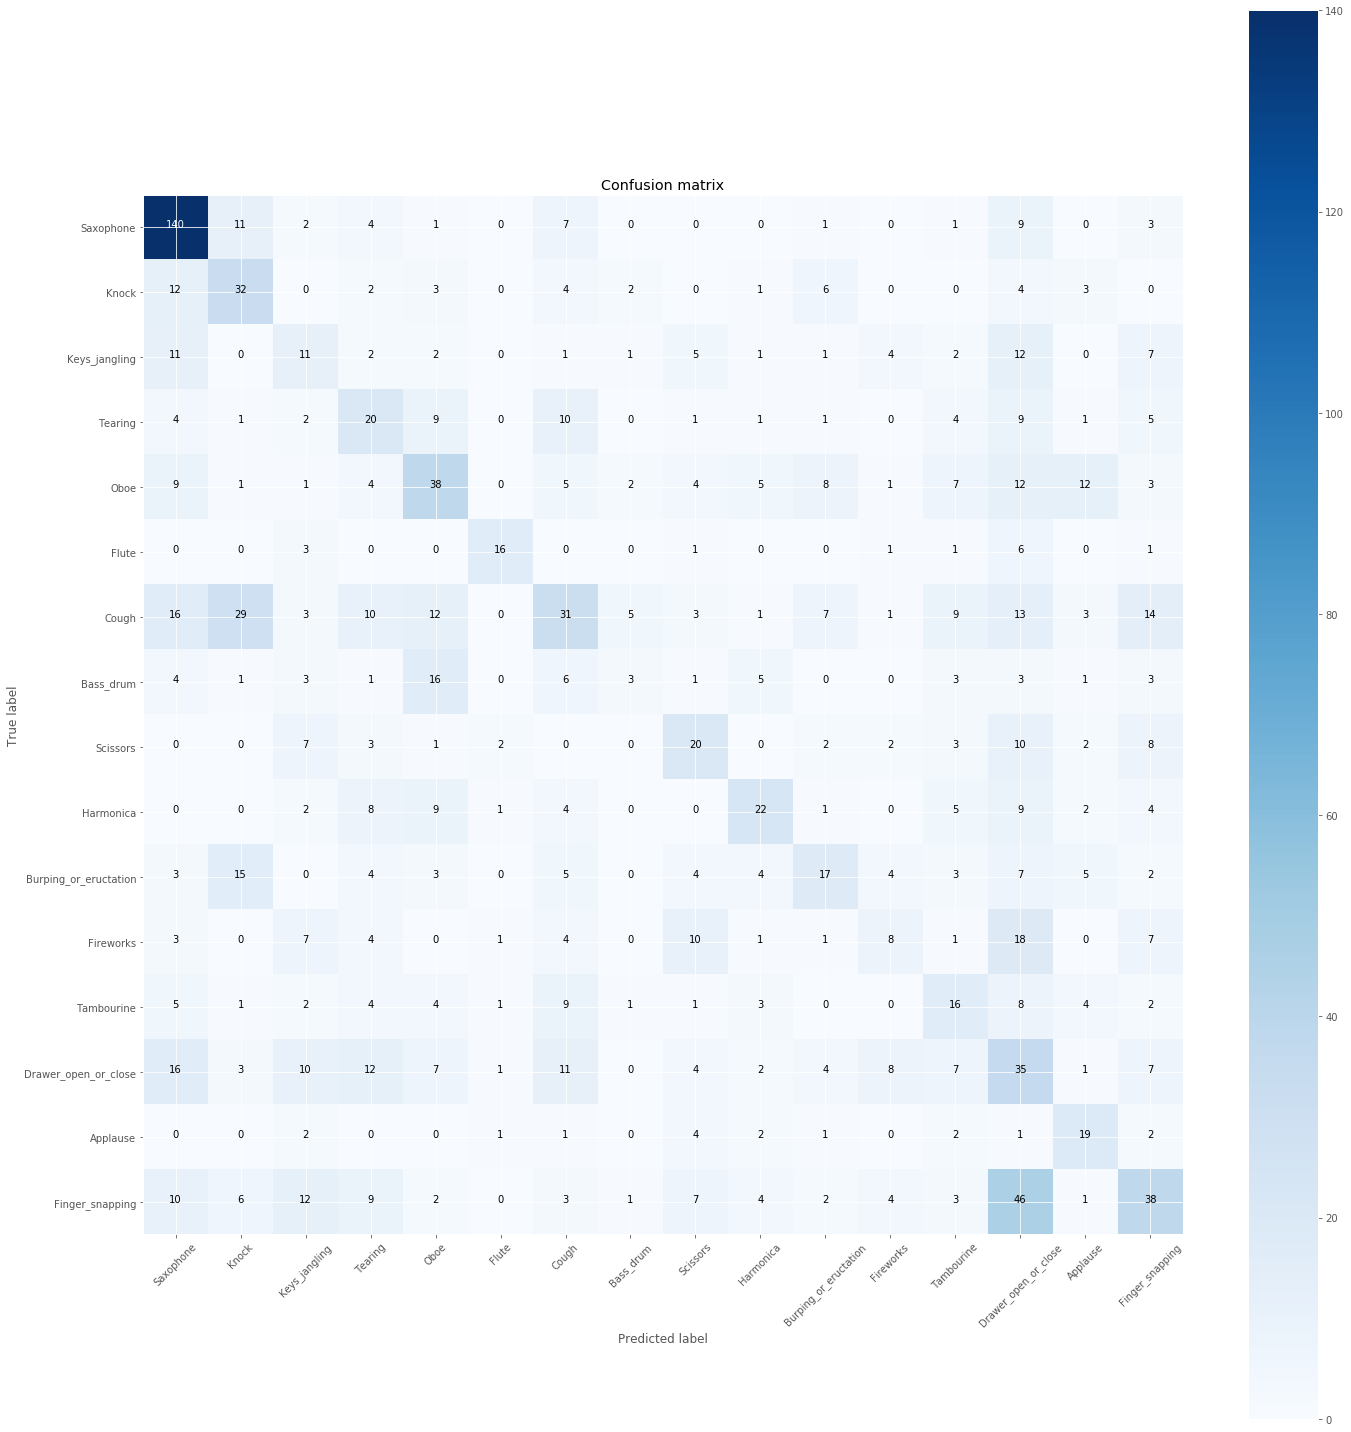

In [54]:
pred = inter.predict(test_i_data)
print(metrics.accuracy_score(test_i_targ, pred))
cm = metrics.confusion_matrix(test_i_targ, pred)
plt.figure(figsize=(20,20))
plot_confusion_matrix(cm, names_i)
plt.show()

# Testing Accuracy of Single File

In [55]:
data_iloc = 1

In [56]:
def load_file_audio_blockwise(file, blocksize=1024, overlap=512, debug=False):
    start_time = time.time()
    items = []
    h_cat = []
    cat = []

    if debug:
        print("File Processing", end="", flush=True)
    blockgen = sf.blocks(audio_dir + file['filename'], 
                         blocksize=blocksize, 
                         overlap=overlap, 
                         always_2d=True, 
                         fill_value=0.0)
    SR = sf.info(audio_dir + file['filename']).samplerate
    for bl in blockgen:
        if not np.any(bl):
            continue
        if debug:
            print(".", end="", flush=True)
        y = bl.transpose()
        y = y[:int(blocksize)]
        y = y[np.newaxis, :]
        items.append(y)
        h_cat.append(file.h_target)
        cat.append(file.target)
    if debug:
        print("Done")

    print("\tProcessing Time: " + str(time.time() - start_time))
    return np.vstack(items), np.array(h_cat), np.array(cat)

In [57]:
x_file, y_file, yy_file = load_file_audio_blockwise(dataset.iloc[data_iloc],
                                                    blocksize,
                                                    overlap)

	Processing Time: 0.003137826919555664


In [58]:
pred_prob = clas.predict_proba(x_file, verbose=1)
pred = clas.predict(x_file, verbose=1)

6/6 [==============================] - 0s 7ms/step


In [59]:
np.average(pred_prob, axis=0)

array([0.01844959, 0.01584469, 0.24704047], dtype=float32)

In [60]:
pred_prob = anim.predict_proba(x_file, verbose=1)
pred = anim.predict(x_file, verbose=1)

6/6 [==============================] - 0s 3ms/step


In [61]:
np.average(pred_prob, axis=0)

array([9.9510199e-01, 1.0536283e-04, 4.1389139e-03, 3.9146352e-04,
       1.7744525e-05, 2.4449910e-04], dtype=float32)

In [62]:
from collections import Counter
b = Counter(pred)
print(b.most_common(1)[0][0])

2


In [63]:
print(dataset.iloc[data_iloc])

filename    001ca53d.wav
target                30
h_target               2
fold                   5
Name: 1, dtype: object


In [64]:
predictions = []
full_targets = []
start_time = time.time()
top_pred_probs = []
pred_probs = []

for data_iloc in range(0,2000):
    x_file, y_file, yy_file = load_file_audio_blockwise(dataset.iloc[data_iloc],
                                                    blocksize,
                                                    overlap)
    pred = clas.predict(x_file, verbose=0)[:,0]
    top_pred_probs.append(clas.predict_proba(x_file))
    prob = np.average(top_pred_probs[-1], axis=0)
    if prob[0] > 0.5:
        pred = anim.predict(x_file, verbose=0)
        b = Counter(pred)
        predictions.append(b.most_common(1)[0][0])
        pred_probs.append(anim.predict_proba(x_file))
    else:
        pred = inter.predict(x_file, verbose=0)
        b = Counter(pred)
        predictions.append(b.most_common(1)[0][0])
        pred_probs.append(inter.predict_proba(x_file))
    
    full_targets.append(yy_file[0])

print("\tProcessing Time: " + str(time.time() - start_time))

	Processing Time: 0.0042078495025634766


IndexError: too many indices for array

In [ ]:
targs = np.vstack(full_targets)

In [ ]:
print(metrics.accuracy_score(full_targets, predictions))
cm = metrics.confusion_matrix(full_targets, predictions)
plt.figure(figsize=(20,20))
plot_confusion_matrix(cm, classes)
plt.show()

In [ ]:
import seaborn as sns

for i in range(0,20):
    prob = pred_probs[i]
    print(dataset.iloc[i])

    xs = np.unique(targets)
    ys = np.average(top_pred_probs[i], axis=0)

    plt.figure(figsize=(5,5))
    sns.barplot(xs, ys)
    
    xs = np.unique(a_targ)
    ys = np.average(prob, axis=0)
    if(len(ys)!=len(xs)):
        xs = np.unique(i_targ)

    plt.figure(figsize=(20,5))
    sns.barplot(xs, ys)
    plt.show()